### Chord detection using pitch class profiles and Essentia algorithms on The Beatles studio discography
##### Music Information Retrieval Course Project, Winter 2019
#### Written by Linda Bedrani

Using the Beatles discography dataset, this notebook will perform a chord detection algorithm using low-level feature extraction from Essentia, and Essentia's ChordsDetection algorithm. The results will be evaluated by comparing to the chord annotations provided on the Isophonics website, which have been tried and true by the MIR community. These annotations are provided in the following format: 

Chris Harte's doctoral dissertation on automatic extraction of harmony information using this same Beatles dataset described the following methodology for frame-based chord recognition: 

• Use of a tuning algorithm to generate a quantised chromagram.
• Generating the tonal centroid based on the 6D pitch class hypertorus.
• Development of the harmonic change detection function (HCDF)
from the tonal centroid.
• Use of peak picked HCDF for chord recognition segmentation.
• Improved peak picking of HCDF for better chord segmentation.

This is illustrated in the block diagram below, taken from this paper:

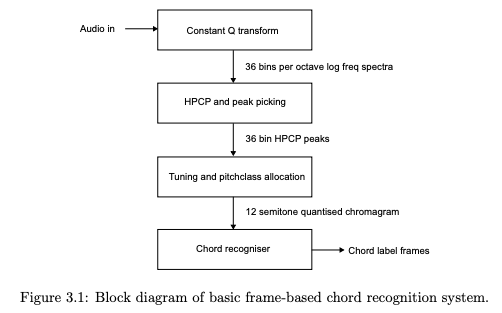

This is not the exact approach I will follow in this notebook. In order to compare the two chord-detecting algorithms from Essentia, I will follow a slightly different chord recognition system for each function.

This block diagram details the approach for ChordsDetection(). The implementation can be seen in the function FrameBasedChordDetection.
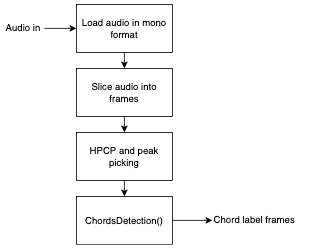

This next block diagram details the approach for ChordsDetectionBeats(). The implementation can be seen in the function BeatBasedChordDetection.

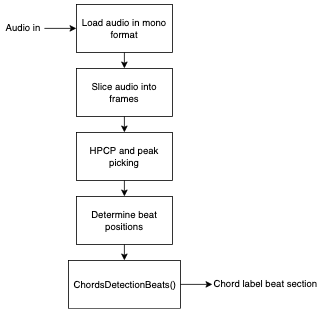

#### Sources for dataset and annotations
Beatles dataset: Provided by author, not included due to copyright and distribution laws. The dataset consists of 12 studio albums by the Beatles:

Please Please Me, With The Beatles, A Hard Day's Night, Beatles For Sale, Help!, Rubber Soul, Revolver, Sgt. Pepper's Lonely Hearts Club Band, Magical Mystery Tour, The Beatles (CD1 and 2), Abbey Road, and Let It Be.

Beatles dataset annotations: http://www.isophonics.net/content/reference-annotations-beatles 

#### Useful references: 
2017 MIREX09: https://www.music-ir.org/mirex/wiki/2017:Audio_Chord_Estimation 
Harte, C. (2010). Towards automatic extraction of harmony information from music signals (Doctoral dissertation). 

### Import libraries and modules

In [1]:
# Import modules
import csv
import pandas as pd
import os
import numpy as np

# Import Essentia
import essentia.standard as ess
import essentia.streaming as esstr
import essentia

# Import plotting modules
from pylab import plot, show, figure, imshow
import matplotlib.pyplot as plt

### Parse through the annotated datasets
We will need to create numpy arrays containing the annotated start time, end time, and chord labels found in each .lab file for each song.

In [2]:
# Load segment annotations from the annotated datasets

def loadAnnotatedSegmentsFromLab(file):

    '''Loads segments annotations from .lab file
    Parameters
    ----------
    file : str
        Audio file name
        
    Returns
    -------
    segments : AnnotatedSegments
    '''
    
    labels = []
    startTimes = []
    durations = []
    folder = './The_Beatles_Annotations/chord lab/The Beatles/01_Please_Please_Me'
    
    #for file in folder:    
    with open(file) as f:
        for line in f:
            start, end, label = line.strip().split(" ")
            labels.append(label)
            startTimes.append(float(start))
            durations.append(float(end) - float(start))
    return np.array(labels, dtype='object'), np.array(startTimes, dtype='float'), np.array(durations, dtype='float')

### Smooth out the chroma features and zero any low-energy frames
These functions can be called to smooth out the chroma before passing it on to further functions or before plotting.

In [3]:
# The following functions will smooth out the chroma features 
# zeroLowEnergy will set all low-energy frames to zero to reduce noise
# smoothChroma will convolve the chroma sequences 

def zeroLowEnergy(chroma, spectra):
    '''
    Borrowed from Lecture4_step2_ChordDetectionDemo
    Set chromas for low energy frames to zero.
    Parameters
    ----------
    chroma : numpy.array(dtype=float)
        chroma data (Nx12)
    spectra : numpy.array(dtype=float)
        audio data
    Returns
    -------
    chroma: numpy.array
    '''
    NRG=np.sum(np.power(spectra,2), axis=1)
    chroma[NRG<np.max(NRG)*NRG_CUTOFF_COEFFICIENT] = np.zeros(12)
    return chroma

def smoothChroma(chroma, hopSize = 4096, fs = 44100):
    '''
    Borrowed from Lecture4_step2_ChordDetectionDemo
    Smooth chroma features by convolving each of 12 chroma sequences with hanning window.
    '''
    return smooth(chroma, window_len=int(SMOOTHING_TIME * fs / hopSize), window='hanning').astype(
                         'float32')

## ChordsDetection

Here, we will load the file in a mono format, slice into frames, perform a spectral analysis to determine spectral peaks, and determine the pitch class profiles.

The ChordsDetection function is used to determine the chord label for each HPCP within each frame. 

In [6]:
def FrameBasedChordDetection(filename, frameSize, tuningFreq=440, hopSize = 8192):
    '''
    Extract HPCP chroma features with essentia
    Parameters
    ----------
    filename: str
        audio file name
    frameSize : int
        Analysis frame size (samples)
    tuningFreq : float
        tuning frequency (Hz)
    hopSize : int
        Hop size (in samples)
    Returns
    -------
    chroma: numpy.array
    spectra: numpy.array
    '''
    loader = esstr.MonoLoader(filename = filename)
    framecutter = esstr.FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = esstr.Windowing(type="blackmanharris62")
    spectrum = esstr.Spectrum()
    spectralpeaks = esstr.SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    hpcp = esstr.HPCP(
        size=12,
        referenceFrequency = tuningFreq,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitSum')
    
    
    chords = esstr.ChordsDetection(
        hopSize = 16384,
        sampleRate = 44100,
        windowSize = 2.0)
    
    pool = essentia.Pool()
    
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectrum.spectrum >> (pool, 'spectrum.magnitude')
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')
    #hpcp.hpcp >> chords.pcp
    #chords.chords >> (pool, 'chords.chords')
    #chords.strength >> (pool, 'strength.chords')

    essentia.run(loader)
    #chroma = pool['chroma.hpcp']
    #spectra = pool['spectrum.magnitude']
    
    #chord = pool['chords.chords']
    #chord_strength = pool['strength.chords']
  
    
    chords = ess.ChordsDetection()
    syms, strengths = chords(pool['chroma.hpcp'])
    
    # Set the energy for low-energy frames to zero and smooth the chroma features
    #chroma = zeroLowEnergy(chroma, spectra)
    #chroma = smoothChroma(chroma)
    
    #chroma = np.array(chroma, dtype=float)
    #spectra = np.array(spectra, dtype=float)
    
    #chords = np.array(chords, dtype=object)
    
    return syms, strengths



## ChordsDetectionBeats

Here, we will load the file in a mono format, slice into frames, perform a spectral analysis to determine spectral peaks, and determine the pitch class profiles. Then the beat positions of the audio will be determined. 

The ChordsDetectionBeats is used to determine the chord label for the HPCP within all beat positions.

In [16]:
def BeatBasedChordDetection(filename) :

    chordHopSize = 4096
    frameSize = 8192
    tuningFreq = 440
    # initialize algorithms we will use
    loader = esstr.MonoLoader(filename=filename)
    framecutter = esstr.FrameCutter(hopSize=chordHopSize, frameSize=frameSize)
    windowing = esstr.Windowing(type="blackmanharris62")
    spectrum = esstr.Spectrum()
    spectralpeaks = esstr.SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = esstr.HPCP(size=12,
                referenceFrequency = tuningFreq,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)
    
    # use pool to store data
    pool = essentia.Pool()
    
    
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    
    essentia.run(loader)
    

    #print 'Loading audio file...', infile
    audio = ess.MonoLoader(filename = filename)()
    bt = ess.BeatTrackerMultiFeature()
    beats, _ = bt(audio)
    beats = beats[::4]

    

    chords = ess.ChordsDetectionBeats()
    syms, strengths = chords(pool['chroma.hpcp'], beats)
    
    #print 'size: ', len(pool['chroma.hpcp'])
    
    return syms, strengths


### Test ChordsDetection with one sound file

In [7]:
soundsDIR = '../audio/'
labsDIR = '../labs/'
sound_file ='06_Let_It_Be.mp3'
lab_file = '02_-_Misery.lab' 

# The Essentia ChordsDetection algorithm assumes that the HPCPs have been calculed with framesize = 2*hopsize, 
# Hop size was set to 4096, so the frame size should be set to 8192

frame_size = 32768

#start, dur, chords = loadAnnotatedSegmentsFromLab(labsDIR+lab_file)
#print(chords)

chord, chord_strength = FrameBasedChordDetection(soundsDIR+sound_file, frame_size)

# Calculate the beat positions to pass to the ChordDetectionBeats function


print(chord)


['C', 'C', 'C', 'C', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 

In [8]:
len(chord)
# Need to fix the frame segmentation for this algorithm. Frames are too short at the moment.

1310

### Test ChordsDetectionBeats with one sound file

In [17]:
chord, chord_strength = BeatBasedChordDetection(soundsDIR+sound_file)
print(chord)

['C', 'Am', 'G', 'C', 'G', 'Am', 'G', 'C', 'G', 'C', 'C', 'C', 'C', 'G', 'C', 'G', 'Am', 'G', 'C', 'C', 'Am', 'Am', 'Gm', 'Am', 'F', 'C', 'C', 'C', 'C', 'G', 'C', 'Am', 'C', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'F', 'G', 'Am', 'C', 'C', 'G', 'F', 'G', 'F', 'Gm', 'C', 'C', 'Am', 'C', 'F', 'Am', 'Am', 'C', 'F', 'Am', 'C', 'C', 'C', 'C', 'C', 'C', 'F', 'C', 'Am', 'C']


### Compare results with chord annotations

### Discussion of results